In [1]:
from dataset import Dataset
import haiku as hk
from jax import random
from jax import vmap
from jax.api import jit
import optax
from jax import grad
import jax.numpy as jnp
import numpy as onp
import torch
from torch.utils.data import DataLoader, Subset
from jax.lib import xla_bridge
import time
# from sam.sam_jax.training_utils import flax_training

print(xla_bridge.get_backend().platform)

gpu


In [2]:
@jit
def update(params, opt_state, batch):
  R, energy, force = batch   
  def energy_loss_fn(params):
    return jnp.mean((vectorized_energy_fn(params, R) - energy) ** 2)
  
  def force_loss_fn(params):
    # We want the gradient with respect to the position, not the parameters.
    grad_fn = vmap(grad(energy_fn, argnums=1), (None, 0))
    return jnp.mean((grad_fn(params, R) + force) ** 2)
  
  def loss_fn(params):
    return energy_loss_fn(params) + force_loss_fn(params)

  updates, opt_state = opt.update(grad(loss_fn)(params), opt_state)
  return optax.apply_updates(params, updates), opt_state, loss_fn(params)

In [3]:
@jit
def eval(params, batch):
  R, energy, force = batch   
  def energy_loss_fn(params):
    return jnp.mean((vectorized_energy_fn(params, R) - energy) ** 2)
  
  def force_loss_fn(params):
    # We want the gradient with respect to the position, not the parameters.
    grad_fn = vmap(grad(energy_fn, argnums=1), (None, 0))
    return jnp.mean((grad_fn(params, R) + force) ** 2)
  
  def loss_fn(params):
    return energy_loss_fn(params) + force_loss_fn(params)
  return  loss_fn(params)

In [4]:
from typing import NamedTuple
from jax_md import space, util
from jax_md.energy import graph_network, behler_parrinello
class FLAGS(NamedTuple):
    KEY = random.PRNGKey(0) 
    BATCH_SIZE = 64
    NUM_WORKERS = 1

In [5]:
training_set = Dataset(is_train=True)
test_set = Dataset(is_train=False)
training_generator = DataLoader(training_set,
                                batch_size=FLAGS.BATCH_SIZE,
                                shuffle=True,
                                num_workers=FLAGS.NUM_WORKERS)
test_generator = DataLoader(test_set,
                            batch_size=250,
                            shuffle=False,
                            num_workers=FLAGS.NUM_WORKERS)

In [6]:
# Box
box_size = 10.862
displacement, shift = space.periodic(box_size)
# Graph Neural Network 
# init_fn, energy_fn = graph_network(displacement, r_cutoff=3.0)
# Symmetric Function + Feedfoward Neural Network
# TODO various hyper parameters
sym_kwargs = { "radial_etas":    jnp.array([9e-4, 0.01, 0.02, 0.035, 0.06, 0.1, 0.2, 0.4],util.f32) / util.f32(0.529177 ** 2),
               "angular_etas":   jnp.array([1e-4] * 4 + [0.003] * 4 + [0.008] * 2 + [0.015] * 4 + [0.025] * 4 + [0.045] * 4,util.f32) / util.f32(0.529177 ** 2),
               "lambdas":        jnp.array([-1, 1] * 4 + [1] * 14, util.f32),
               "zetas":          jnp.array([1, 1, 2, 2] * 2 + [1, 2] + [1, 2, 4, 16] * 3, util.f32),
               "cutoff_distance": 3.0 }
# 
init_fn, energy_fn = behler_parrinello(displacement, sym_kwargs=sym_kwargs)
params = init_fn(FLAGS.KEY, training_set[0][0])
vectorized_energy_fn = vmap(energy_fn, (None, 0))
opt = optax.chain(optax.clip_by_global_norm(0.01), optax.adam(1e-4))
opt_state = opt.init(params)
trajectory = jnp.zeros((0,3))
for epoch in range(30):
    train_start = time.time()
    train_loss = 0
    cnt = 0
    for Rs, Es, Fs in training_generator:
        batch = (jnp.array(Rs), jnp.array(Es), jnp.array(Fs))
        params, opt_state, loss = update(params, opt_state, batch)
        train_loss += loss
        cnt += 1
    train_loss = train_loss / cnt
    train_end = time.time()
    test_start = time.time()
    test_loss = 0
    cnt = 0
    for Rs, Es, Fs in test_generator:
        batch = (jnp.array(Rs), jnp.array(Es), jnp.array(Fs))
        test_loss += eval(params, batch)
        cnt += 1
    test_loss = test_loss / cnt
    test_end = time.time()
    print(f'Train Loss at Epoch \t {epoch} is {train_loss} \t ({train_end - train_start} sec)')
    print(f'Test Loss at Epoch \t {epoch} is {test_loss}   \t ({test_end - test_start} sec)')
    trajectory = jnp.concatenate((trajectory, jnp.array([[epoch,train_loss,test_loss]])))
jnp.save("results/trajectory", trajectory)

/home1/ibayashi/anaconda3/envs/md_precision/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:2070: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, name)


Train Loss at Epoch 	 0 is 128998.6171875 	 (29.09816551208496 sec)
Test Loss at Epoch 	 0 is 126882.421875   	 (9.601495742797852 sec)
Train Loss at Epoch 	 1 is 124805.8671875 	 (14.51506757736206 sec)
Test Loss at Epoch 	 1 is 122594.1484375   	 (1.7817304134368896 sec)
Train Loss at Epoch 	 2 is 120388.3828125 	 (14.550671339035034 sec)
Test Loss at Epoch 	 2 is 118005.0625   	 (1.7791192531585693 sec)
Train Loss at Epoch 	 3 is 115623.4609375 	 (14.385292291641235 sec)
Test Loss at Epoch 	 3 is 112999.4921875   	 (1.767425298690796 sec)
Train Loss at Epoch 	 4 is 110391.9765625 	 (14.530689477920532 sec)
Test Loss at Epoch 	 4 is 107521.765625   	 (1.7950336933135986 sec)
Train Loss at Epoch 	 5 is 104694.5 	 (14.543746948242188 sec)
Test Loss at Epoch 	 5 is 101579.046875   	 (1.7911536693572998 sec)
Train Loss at Epoch 	 6 is 98545.3515625 	 (14.53681206703186 sec)
Test Loss at Epoch 	 6 is 95206.7734375   	 (1.7955412864685059 sec)
Train Loss at Epoch 	 7 is 92003.9921875 	 (14

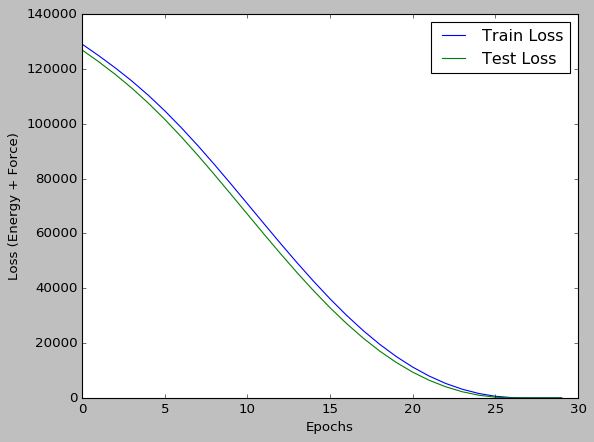

In [9]:
import matplotlib.pyplot as plt
def draw(trajectory):
    epochs = trajectory[:,0]
    train_loss = trajectory[:,1]
    test_loss = trajectory[:,2]
    plt.style.use('classic')
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, test_loss, label="Test Loss")
    plt.ylabel('Loss (Energy + Force)')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()
draw(trajectory)

In [11]:
import json
def dump2json(params,sym_params,file_name):
    out_dict = {}
    sym_hyper_parameters = {}
    for param_name in sym_params:
        if isinstance(sym_params[param_name], jnp.ndarray):
            sym_hyper_parameters[param_name] = sym_params[param_name].tolist()
        else:
            sym_hyper_parameters[param_name] = sym_params[param_name]
    out_dict["sym_hyper_parameters"] = sym_hyper_parameters
    for i, layer in enumerate(params):
        layer_dict = {}
        layer_dict['Weight'] = params[layer]['w'].tolist()
        layer_dict['Bias'] = params[layer]['b'].tolist()
        out_dict[f'Layer {i}'] = layer_dict
    out_dict["Activation"] = "Relu"
    with open(file_name, 'w') as f:
        json.dump(out_dict, f)
dump2json(params, sym_kwargs, "trained_params.json")